<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

from tqdm import tqdm

from skimage.transform import resize

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = "gdrive/My Drive/lung_cancer/"

In [0]:
img_path = PATH+'image/'
label_path = PATH+'mask/'

In [35]:
img_ids = next(os.walk(img_path))[2]
label_ids = next(os.walk(label_path))[2]
img_ids.sort()
label_ids.sort()
print(len(img_ids))
print(len(label_ids))

742
742


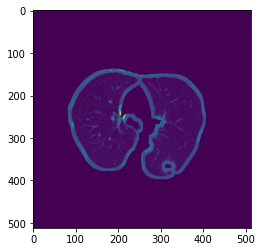

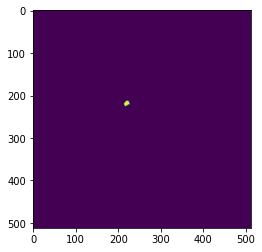

In [26]:
# i=5
# img = imread(img_path + img_ids[i])
# plt.imshow(img)
# plt.show()
# label = imread(label_path + label_ids[i])
# plt.imshow(label)
# plt.show()


In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [64]:
X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path + id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(label_ids), total=len(label_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = label_path + id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 742/742 [00:08<00:00, 83.29it/s]


In [0]:
ind_list = [i for i in range(len(X_train))]
random.shuffle(ind_list)
X_train_shuffled = X_train[ind_list]
Y_train_shuffled = Y_train[ind_list]

In [0]:
X_train_shuffled

In [63]:
a = np.array([1,2,3,4,5])
ind = [0,1,2,3,4]
random.shuffle(ind)
print(a[ind])

[3 2 4 5 1]


image_LIDC-IDRI-0003_1_1.png


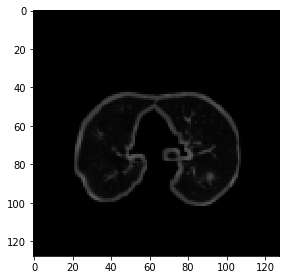

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


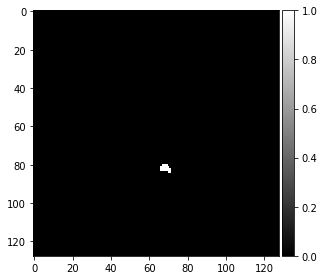

In [27]:
# ix = random.randint(0, len(one_ids))
# print(img_ids[ix])
# imshow(X_train[ix][:,:,0])
# plt.show()
# imshow(Y_train[ix][:,:,0],cmap=plt.cm.gray)
# plt.show()

In [14]:
# Define IoU metric
from keras import backend as K
# def iou(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.bool)
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
#     iou = (intersection) / (union)
#     return iou


# def iou_loss(y_true, y_pred):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
#     iou = (intersection) / (union)
#     return -iou

def iou(y_true, y_pred):
    intersection = (y_true[:,:,0]*y_pred[:,:,0]).sum()
    union =y_true[:,:,0].sum() + y_pred[:,:,0].sum() - intersection
    return intersection/union



# def iou(y_true, y_pred):
#     intersection = tf.reduce_sum(y_true[:,:,0]*y_pred[:,:,0])
#     union =tf.reduce_sum(y_true[:,:,0]) + tf.reduce_sum(y_pred[:,:,0]) - intersection
#     return intersection/union

Using TensorFlow backend.


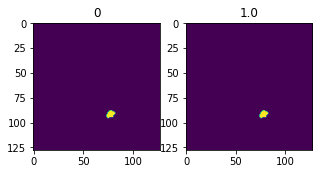

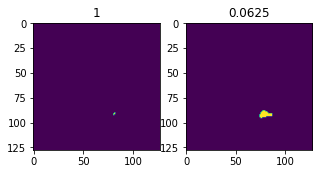

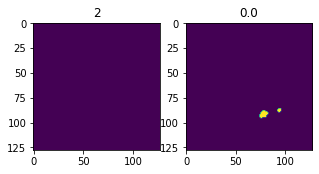

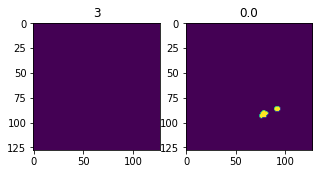

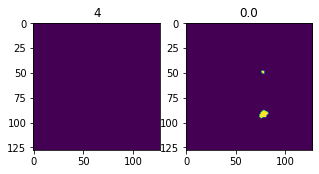

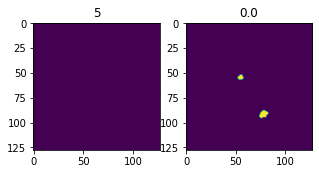

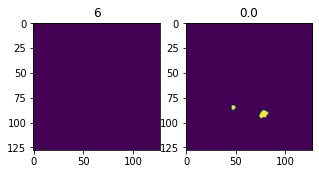

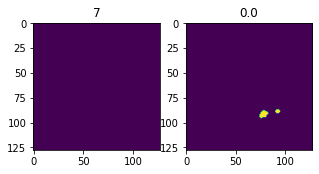

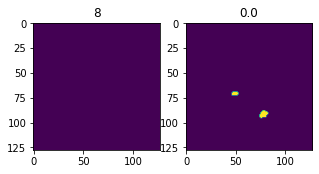

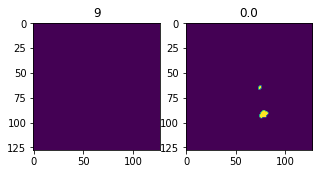

In [20]:
# # print(mean/_iou(Y_train[0], Y_train[0]))
# for i in range(10):
#     fig, ax = plt.subplots(1,2,figsize=(5,3))
#     ax[0].imshow((Y_train[0] * Y_train[i])[:,:,0])
#     # plt.show()
#     ax[0].title.set_text(i)
#     ax[1].imshow((Y_train[0] + Y_train[i])[:,:,0])
#     # plt.show()
#     intersection = (Y_train[0] * Y_train[i]).sum()
#     union = (Y_train[0].sum()) + (Y_train[i].sum()) - intersection
#     ax[1].title.set_text(intersection/union)
#     plt.show()

In [77]:
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
adam = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss='binary_crossentropy')

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 128, 128, 1)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 16) 160         lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_55 (Dropout)            (None, 128, 128, 16) 0           conv2d_115[0][0]                 
____________________________________________________________________________________________

In [78]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=1, save_best_only=True)
with tf.device('/device:GPU:0'):
    results = model.fit(X_train_shuffled, Y_train_shuffled, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 667 samples, validate on 75 samples
Epoch 1/100
667/667 [==============================] - 5s 7ms/step - loss: 0.3276 - val_loss: 0.0145

Epoch 00001: val_loss improved from inf to 0.01446, saving model to model-dsbowl2020-4.h5
Epoch 2/100
667/667 [==============================] - 3s 4ms/step - loss: 0.0119 - val_loss: 0.0117

Epoch 00002: val_loss improved from 0.01446 to 0.01168, saving model to model-dsbowl2020-4.h5
Epoch 3/100
667/667 [==============================] - 3s 4ms/step - loss: 0.0104 - val_loss: 0.0105

Epoch 00003: val_loss improved from 0.01168 to 0.01048, saving model to model-dsbowl2020-4.h5
Epoch 4/100
667/667 [==============================] - 3s 4ms/step - loss: 0.0096 - val_loss: 0.0100

Epoch 00004: val_loss improved from 0.01048 to 0.00998, saving model to model-dsbowl2020-4.h5
Epoch 5/100
667/667 [==============================] - 3s 4ms/step - loss: 0.0090 - val_loss: 0.0086

Epoch 00005: val_loss improved from 0.00998 to 0.00857, saving model to m

In [79]:
# Predict on train, val and test
# model = load_model('model-dsbowl2020-4.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

75/75 [==============================] - 0s 941us/step


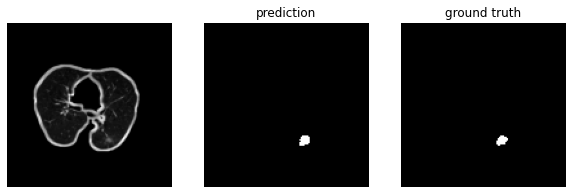

iou :  0.8214285714285714


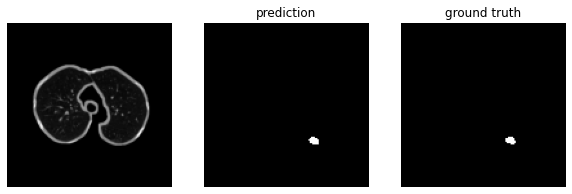

iou :  0.8461538461538461


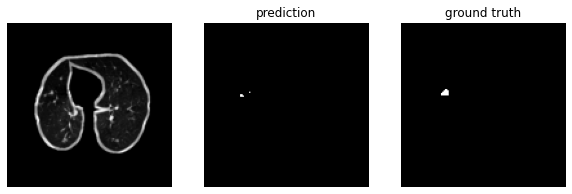

iou :  0.03571428571428571


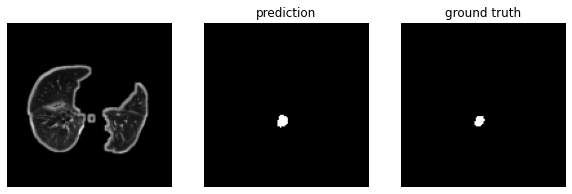

iou :  0.8032786885245902


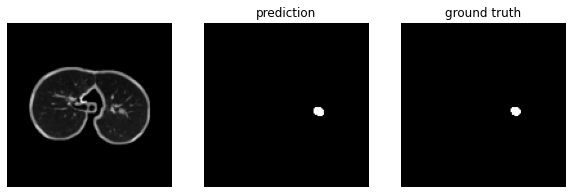

iou :  0.9361702127659575


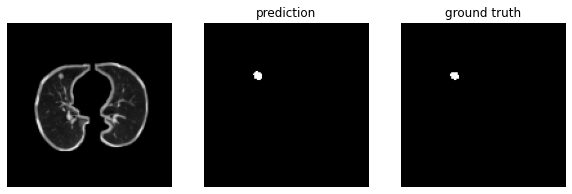

iou :  0.8611111111111112


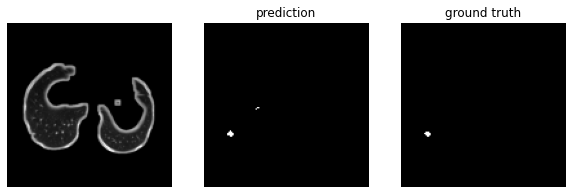

iou :  0.7368421052631579


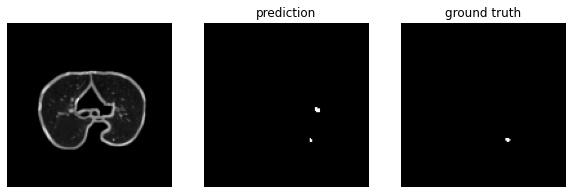

iou :  0.22727272727272727


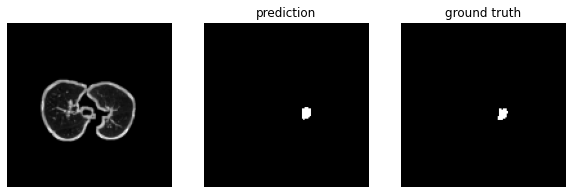

iou :  0.7903225806451613


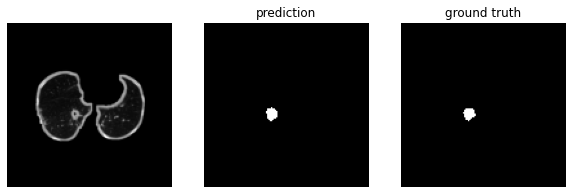

iou :  0.863013698630137
[0.82142857 0.87951807 0.8989899  0.87610619 0.94117647 0.90526316
 0.84615385 0.85714286 0.36842105 0.38297872 0.77272727 0.81690141
 0.775      0.84705882 0.95238095 0.90697674 0.86666667 0.85882353
 0.84       0.87837838 0.68421053 0.796875   0.83018868 0.88888889
 0.69767442 0.57894737 0.65625    0.5        0.58333333 0.84615385
 0.65909091 0.82608696 0.82       0.92307692 0.72580645 0.69491525
 0.23076923 0.35714286 0.6875     0.82539683 0.70512821 0.79166667
 0.77966102 0.87804878 0.76470588 0.79591837 0.86206897 0.95
 0.88235294 0.89393939 0.86792453 0.         0.33333333 0.22727273
 0.08823529 0.21875    0.56756757 0.66666667 0.56       0.
 0.66666667 0.52173913 0.70588235 0.91304348 0.77419355 0.76086957
 0.8627451  0.84848485 0.86363636 0.82894737 0.86075949 0.86764706
 0.76785714 0.81481481 0.625      0.72727273 0.75       0.9
 0.5        0.5625     0.61111111 0.47058824 0.83333333 0.5625
 0.55555556 0.66666667 0.25       0.36363636 0.625      0.875


In [80]:
iou_vec = np.array([])
for i in range(10):
    ix = random.randint(0, len(preds_train_t))
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(X_train[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_train_t[ix][:,:,0]),cmap='gray')
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(Y_train[ix][:,:,0]),cmap='gray')
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    print("iou : ",iou(preds_train_t[ix].astype(np.bool),Y_train[ix]))
    # print(preds_train_t[ix].astype(np.bool).shape)
    # preds_train_t[ix].astype(np.bool) + 
for i in range(len(preds_train_t)):
    iou_vec = np.append(iou_vec, iou(preds_train_t[i].astype(np.bool),Y_train[i]))
print(iou_vec)
print(iou_vec.mean())

In [81]:
np.where(iou_vec>0,1,0).mean()

0.95952023988006